In [33]:
import os
from tabulate import tabulate
from bs4 import BeautifulSoup
from tabulate import tabulate

class JEMHEphemeraDoc:
    """
        Data members: (should be self explanatory)
        fileName            | str
        filesDir            | str
        year                | int
        placeOfPublication  | str
        text                | str list
        rawSize_ch          | int | # of chars in body of document
        """

    """
    JEMHDocParser is used to read the XML files where ephemera from JEMH corpus are stored.
    """

    # inner class to read XML files of ephemera
    class JEMHEphemeraDocParser:
        @staticmethod
        def createSoup(fileName, fileDir):
            infile = open(fileDir + "/" + fileName, "r")
            soup = BeautifulSoup(infile.read(), 'xml')

            return soup

        @staticmethod
        def parseMetadata(fileName, fileDir):

            soup = JEMHEphemeraDoc.JEMHEphemeraDocParser.createSoup(fileName, fileDir)
            
            date = soup.find('date')
            year = int(date['when'][0:4])

            # xml address to place of publication
            placeOfPublication = soup.find('pubPlace').get_text()

            return year, placeOfPublication

        @staticmethod
        def parseText(fileName, fileDir):
            soup = JEMHEphemeraDoc.JEMHEphemeraDocParser.createSoup(fileName, fileDir)
            texts = soup.find_all('p')
            corp = [text.get_text() for text in texts]
            return corp
        
        def getRaw_Size_ch(sentence_list):
            size = 0
            
            for sentence in sentence_list:
                size += len(sentence)
                
            return size

    def __init__(self, fileName, fileDir):
        self.fileName = fileName
        self.fileDir = fileDir

        self.year, self.placeOfPublication = JEMHEphemeraDoc.JEMHEphemeraDocParser.parseMetadata(fileName, fileDir)
        self.text = JEMHEphemeraDoc.JEMHEphemeraDocParser.parseText(fileName, fileDir)
        self.raw_size_ch = JEMHEphemeraDoc.JEMHEphemeraDocParser.getRaw_Size_ch(self.text)

    def __iter__(self):
        return (t for t in self.fileName)

    def __str__(self):
        file = self.fileName + '\n'
        year_and_place = self.placeOfPublication + ", " + str(self.year) + '\n'
        body = ""
        for t in self.text:
            body += t + '\n'

        return file + year_and_place + body

    # Accessors
    def getFileName(self):
        return self.fileName

    def getFileDir(self):
        return self.fileDir

    def getYear(self):
        return self.year

    def getPlaceOfPublication(self):
        return self.placeOfPublication

    def getText(self):
        return self.text
    
    def getRaw_Size_ch(self):
        return self.raw_size_ch

    def getMetadata(self):
        return self.fileName, self.year, self.placeOfPublication

In [34]:
import pandas as pd

class JEMHEphemeraFrame:
    
    def __init__(self, fileDir):
        if type(fileDir) == str:
            self.docs = [JEMHEphemeraDoc(file, fileDir) for file in os.listdir(fileDir) if file.endswith('.xml')]
        elif type(fileDir) == list:
            self.docs = [file for file in fileDir]
        else:
            self.docs = []
         
        fileNames = [doc.getFileName() for doc in self.docs]
        fileDirs = [doc.getFileDir() for doc in self.docs]
        years = [doc.getYear() for doc in self.docs]
        PlacesofPublication = [doc.getPlaceOfPublication() for doc in self.docs]
        texts = [doc.getText() for doc in self.docs]
        raw_sizes_ch = [doc.getRaw_Size_ch() for doc in self.docs]
        
        dfData = {'fileName' : fileNames, 'fileDir' : fileDirs, 'Year' : years, 'Place of Pub' : PlacesofPublication, 'Raw_Size_ch' : raw_sizes_ch}
        
        self.df = pd.DataFrame(dfData)

    def __str__(self):
        header = ['File Name', 'Year', 'Place']
        return tabulate([doc.getMetadata() for doc in self.docs], header)

    def __iter__(self):
        return [doc for doc in self.docs]

    def getDocs(self):
        return self.docs
    
    def getFrame(self):
        return self.df

    def filterYear(self, year):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() == year])

    def filterBetweenYears(self, startYear, endYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() in range(startYear, endYear)])

    def filterBeforeYear(self, endYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() < endYear])

    def filterAfterYear(self, startYear):
        return JEMHEphemeraFrame([doc for doc in self.docs if doc.getYear() >= startYear])


In [35]:
TESTDIR_EPHEMERA = 'JEMHCorpus/ephemera/street_ads/TEI'

corp = JEMHEphemeraFrame(TESTDIR_EPHEMERA)

In [36]:
# cas was here
# Filter WW2 1939-1945
corpus = corp.getFrame()
start = corpus["Year"] >= 1939
end = corpus["Year"] <= 1945
during = start & end
ww2 = corpus.loc[during]
print(ww2)

## broken

          fileName                             fileDir  Year Place of Pub  \
12   700173333.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
16   700173509.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
23   700173682.xml  JEMHCorpus/ephemera/street_ads/TEI  1943         חיפה   
24   700173696.xml  JEMHCorpus/ephemera/street_ads/TEI  1941         חיפה   
25   700173683.xml  JEMHCorpus/ephemera/street_ads/TEI  1943         חיפה   
..             ...                                 ...   ...          ...   
225  700172551.xml  JEMHCorpus/ephemera/street_ads/TEI  1945         חיפה   
231  700173317.xml  JEMHCorpus/ephemera/street_ads/TEI  1945         חיפה   
233  700172814.xml  JEMHCorpus/ephemera/street_ads/TEI  1945         חיפה   
236  700173505.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
238  700173707.xml  JEMHCorpus/ephemera/street_ads/TEI  1941         חיפה   

     Raw_Size_ch  
12           386  
16           444  
23           718  

In [37]:
#Filter ww2 documents only
corp_1939_1945 = corp.filterBetweenYears(1939, 1945)

print(corp_1939_1945.getFrame())

         fileName                             fileDir  Year Place of Pub  \
0   700173333.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
1   700173509.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
2   700173682.xml  JEMHCorpus/ephemera/street_ads/TEI  1943         חיפה   
3   700173696.xml  JEMHCorpus/ephemera/street_ads/TEI  1941         חיפה   
4   700173683.xml  JEMHCorpus/ephemera/street_ads/TEI  1943         חיפה   
5   700173653.xml  JEMHCorpus/ephemera/street_ads/TEI  1942         חיפה   
6   700173782.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
7   700173581.xml  JEMHCorpus/ephemera/street_ads/TEI  1939         חיפה   
8   700173409.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
9   700173569.xml  JEMHCorpus/ephemera/street_ads/TEI  1939         חיפה   
10  700173780.xml  JEMHCorpus/ephemera/street_ads/TEI  1944         חיפה   
11  700173790.xml  JEMHCorpus/ephemera/street_ads/TEI  1942         חיפה   
12  70017378

In [ ]:
# hello Iyanu, be sure to clone the corpus into a directory named JEMHCorpus
# I also had to pip install tabulate and pip install lxml

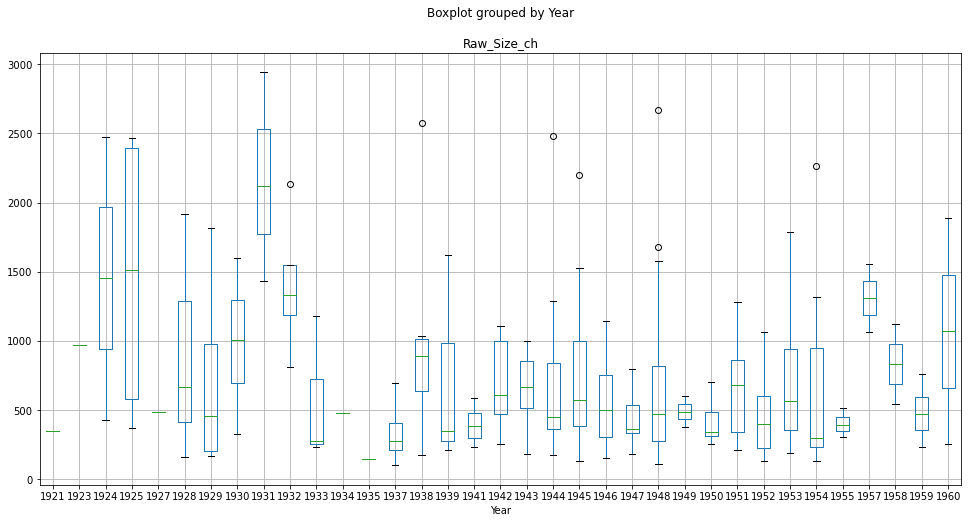

In [42]:
import matplotlib.pyplot as plt
import numpy as np

#box plot of entire corpus

corp_frame = corp.getFrame()

corp_frame.boxplot(column='Raw_Size_ch', by='Year', figsize=(16,8))

plt.show()